# Exploring the EvalRS dataset

This notebook provides some basic EDA on the dataset of the [EvalRS](https://reclist.io/cikm2022-cup/) challenge.
Please refer to [our paper](https://arxiv.org/abs/2207.05772) for all the details.

With the goal of building a *all-around* recommender system, we likely want to understand how users, tracks and listening events are distributed, with a special case to *long tails* and rare (or new events). Yeah, you can thank us for the tip later.

Before we start, we need to clone the official repository and run a few setup steps and imports.

In [1]:
%%capture
!git clone https://github.com/RecList/evalRS-CIKM-2022
!pip install -r evalRS-CIKM-2022/requirements.txt

In [1]:
import sys
if "./evalRS-CIKM-2022" not in sys.path:
    sys.path.append("./evalRS-CIKM-2022")

In [2]:
from evaluation.EvalRSRunner import ChallengeDataset

import gc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")

/home/attanasiog/miniconda3/envs/evalrs/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Next, we have to download the dataset (~600MB) -- actually, you'll download it just the first time!

In [3]:
dataset = ChallengeDataset()

LFM dataset already downloaded. Skipping download.
Loading dataset.
Generating folds.
Generating dataset hashes.


And get a sample fold (see details on our Bootstrapping Cross-Validation evaluation strategy to know more about folds).

In [4]:
train, test = dataset.get_sample_train_test()
train.shape, test.shape

((6907029, 6), (29736, 2))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6907029 entries, 2571 to 1052853902
Data columns (total 6 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int32
 1   artist_id         int32
 2   album_id          int32
 3   track_id          int32
 4   timestamp         int32
 5   user_track_count  int32
dtypes: int32(6)
memory usage: 210.8 MB


So. We have ~7M training listening records. Each tells us who (*user_id*) listened to what (*track_it*), when (*timestamp*), and how many times (*user_track_count*).

Let's now run some preprocessing to get started.

In [6]:
# convert the timestamp in a more convenient format
train["timestamp"] = pd.to_datetime(train["timestamp"], unit="s")

In [7]:
# add a column for Hour Of the Day
train["hod"] = train["timestamp"].dt.hour

We are ready to do some EDA.

## EDA on Tracks

Let's begin with a few statistics about tracks. We can inspect how many *unique* tracks are there! 

In [8]:
percentiles = np.arange(1, step=0.1)
gb_track = train.groupby("track_id")

**Q0: what's the Track distribution?**

In [9]:
track_records = gb_track.size()
track_records.describe(percentiles)

count    227902.000000
mean         30.307014
std          42.163078
min           8.000000
0%            8.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          27.000000
80%          36.000000
90%          59.000000
max        1597.000000
dtype: float64

There are ~230K distinct tracks. But wait. We know there is a `timestamp` feature, does that mean that a user can play the same track multiple times? Programmatically, we should check if the pair <`user`,`track`> does appear multiple times.

In [10]:
len(train.groupby(["user_id", "track_id"]).size()) == train.shape[0]

True

In [11]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,hod
2571,21072247,15,19,22,2013-07-21 22:23:39,5,22
2574,21072247,15,19,25,2013-07-23 11:41:47,3,11
2583,21072247,15,123,26,2012-10-28 10:15:18,9,10
2592,21072247,15,19,30,2013-07-21 22:16:08,4,22
2599,21072247,15,19,31,2013-07-21 13:23:31,7,13


The two sizes correspond: we can assume there are no <`user`,`track`> duplicates. Indeed, the `user_track_count` value lets us know the play count!

We also obtained a new information: `track_records` contains the number of distinct users that played a given track. Let's now observe the distribution graphically.

Text(0, 0.5, 'Track Count (log)')

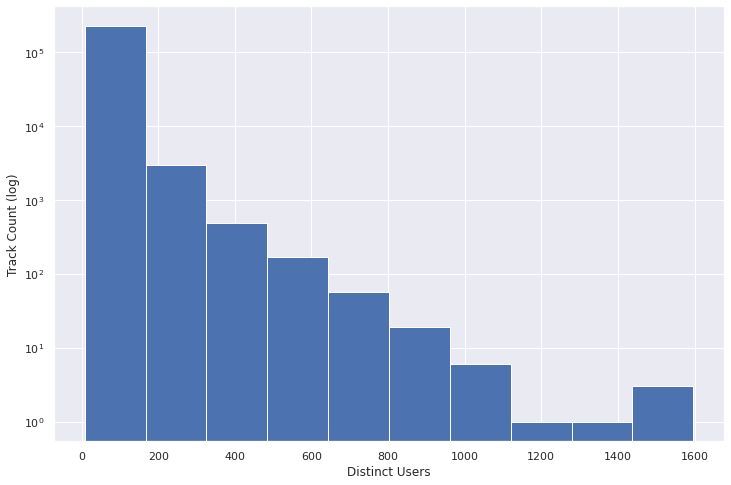

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(track_records)
ax.set_yscale("log")
ax.set_xlabel("Distinct Users")
ax.set_ylabel("Track Count (log)")

Let's look at the distribution in percentiles again. 

In [13]:
track_records.describe(percentiles)

count    227902.000000
mean         30.307014
std          42.163078
min           8.000000
0%            8.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          27.000000
80%          36.000000
90%          59.000000
max        1597.000000
dtype: float64

Tracks are listened by 30 distinct users on the average, and that 90% of them has less than 58 distinct users that played it. Further, there are some outliers: the maximum number of users is ~1600. Is this a very popular track or a dataset artifact? Let's find out.   

In [14]:
K = 10
top_by_user = track_records.iloc[track_records.argsort().values[:-(K+1):-1]]
top_by_user.name = "distinct_user_count"

# Retrieve the task information from the `dataset` handler variable
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,distinct_user_count
track_id,,,,,,
4868,Rolling in the Deep,504,Adele,"[1518, 18942, 64876, 66600, 80986, 93573, 9761...","['21', '19', '21 (Deluxe Edition)', 'monday_pl...",1597
26142,We Are Young (feat. Janelle Monáe),3151,fun.,"[6907, 9619, 53139, 162664, 238945, 246098, 27...","['Some Nights', 'We Are Young', nan, 'The Best...",1484
11393952,Somebody That I Used to Know,3085,Gotye,"[20107, 33321, 90034, 103479, 107493, 158828, ...","['Making Mirrors (Deluxe Edition)', 'Somebody ...",1451
16110,Get Lucky (feat. Pharrell Williams),320,Daft Punk,"[5331, 10200, 11728, 40809, 84112, 95892, 1237...","['Random Access Memories', 'Get Lucky', 'Homew...",1391
14034,We Found Love (feat. Calvin Harris),355,Rihanna,"[4961, 6808, 14253, 18206, 18254, 19802, 40014...","['We Found Love', 'The Official Uk Top 40 Sing...",1242
51176,Titanium (feat. Sia),1935,David Guetta,"[16065, 18345, 18845, 32658, 40236, 80698, 875...","['Best of...', 'Nothing but the Beat 2.0', 'No...",1108
28847,Get Lucky (Radio Edit) [feat. Pharrell Williams],320,Daft Punk,"[10200, 19277, 136209, 188202, 269754, 361728,...","['Get Lucky', nan, 'Random Access Memories', '...",1100
572665,Set Fire to the Rain,504,Adele,"[1518, 64876, 93573, 98525, 116649, 143113, 14...","['21', '21 (Deluxe Edition)', 'Rolling in the ...",1068
14775,Give Life Back to Music,320,Daft Punk,"[5331, 95892, 136209, 167688, 429072, 472207, ...","['Random Access Memories', 'Random Access Memo...",1029


Well, these song seem pretty popular, right? But something more came up... look at position **3** and **6**: there are two different versions of *Get Lucky*. Is this something you want your model to factor in at training time? 

**Q1: How many times does a user play the same song?**

We can use the handy `user_track_count` to measure how frequently users get engaged by songs (remember to take a look at all the columns in `dataset.df_users`, there are very userful variable there).

In [15]:
avg_play_count = gb_track["user_track_count"].mean()
avg_play_count.describe(percentiles)

count    227902.000000
mean          2.533773
std           2.873777
min           1.000000
0%            1.000000
10%           1.250000
20%           1.405405
30%           1.578947
40%           1.758621
50%           1.976190
60%           2.230769
70%           2.580645
80%           3.111111
90%           4.200000
max         500.615385
Name: user_track_count, dtype: float64

On the average, a user repeats a given track ~2.6 times. Again, let's inspect our tail.

In [16]:
top_by_user = avg_play_count.iloc[avg_play_count.argsort().values[:-(K+1):-1]]
top_by_user.name = "avg_play_count"
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,avg_play_count
track_id,,,,,,
524819,Fade Into Me,59718,David Cook,"[185432, 345497, 3655166, 4282962, 14730651]","['This Loud Morning (Deluxe Version)', 'This L...",500.615385
707141,Bastava,6319,Laura Pausini,"[257911, 568326, 3710046, 6487077]","['Inedito', 'Inedito (Deluxe Edition)', 'Inedi...",450.090909
100848,Slow Me Down,15692,Anneke van Giersbergen,"[33336, 7100104]","['Everything Is Changing', 'Everything Is Chan...",287.461538
100465,Planetary Confinement,15654,Antimatter,"[33249, 521899]","['Planetary Confinement', 'Planetary Confineme...",250.214286
403143,Bombed,4721,Mark Lanegan,"[66064, 223535, 1101069, 1101180, 4129582, 641...","['Bubblegum', 'Bubblegum', 'Has God Seen My Sh...",219.764706
176516,20.000 Miles Over the Sea,48,Enigma,"[917, 60733]","['A Posteriori', 'A Posteriori (Advance)']",200.941176
994735,Circadian,59718,David Cook,"[185432, 345497, 3655166, 4282962]","['This Loud Morning (Deluxe Version)', 'This L...",195.333333
361822,Bury Me in Vegas,14005,Eskimo Callboy,[125035],['Bury Me in Vegas'],182.666667
362676,Youth Gone Wild (Skid Row cover),8988,Asking Alexandria,"[84931, 118455, 125624]","['Life Gone Wild', 'Life Gone Wild EP', 'Life ...",175.333333


Here it is a new piece of information: the top 10 tracks by number of play counts is completely different than the one by number of distinct users.

In [17]:
# Cleanup..
del gb_track
del avg_play_count
del track_records
del top_by_user
_ = gc.collect()

## EDA on Users 

Let's move to users now.

In [18]:
gb_user = train.groupby("user_id")

In [19]:
user_records = gb_user.size()

In [20]:
user_records.describe(percentiles=percentiles)

count    29736.000000
mean       232.278349
std        108.022859
min          9.000000
0%           9.000000
10%         77.000000
20%        128.000000
30%        170.000000
40%        207.000000
50%        239.000000
60%        269.000000
70%        300.000000
80%        333.000000
90%        373.000000
max        498.000000
dtype: float64

There are almost 30K distinct users in our dataset. The average number of song they played is 232 with some binge listener that made it to 494.

What about their demographics?

In [21]:
train_users = train.join(dataset.df_users, on="user_id", rsuffix="_data")

In [22]:
gb_train_users = train_users.groupby("user_id")

In [23]:
gb_train_users.first().gender.value_counts(normalize=True, dropna=False)

n       0.529157
m       0.337941
f       0.131356
None    0.001547
Name: gender, dtype: float64

Only half of our users are annotated with (binary) gender, and there is a significant skew towards males.

In [24]:
users_by_country = gb_train_users.first().country.value_counts(normalize=True, sort=True, ascending=False, dropna=False)
users_by_country

None    0.537564
US      0.088210
RU      0.042137
DE      0.038102
UK      0.037900
          ...   
CV      0.000034
BW      0.000034
SZ      0.000034
LK      0.000034
LI      0.000034
Name: country, Length: 162, dtype: float64

In [25]:
top_countries = gb_train_users.first().country.value_counts(dropna=True, sort=True, ascending=False)[:10]
top_countries

US    2623
RU    1253
DE    1133
UK    1127
PL    1072
BR     987
NL     366
FI     359
SE     331
ES     308
Name: country, dtype: int64

Text(0, 0.5, 'Count')

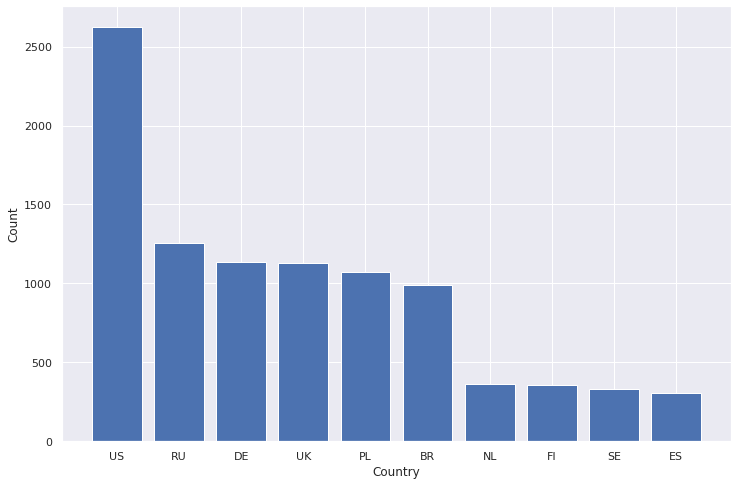

In [26]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x=top_countries.index, height=top_countries.values)
ax.set_xlabel("Country")
ax.set_ylabel("Count")

There are 158 distinct countries but only half of the users are annotated with that information. Most of the users was logged from the United States.

In [27]:
del gb_user
del gb_train_users
del top_countries
_ = gc.collect()

## Analysis on listening events

We have explored relationships between users and tracks. But what about the playing time and hour? 

For example, one might search for any correlation between listening events and hour of the day. 

**Q0: Is there any listening pattern across hours of the day?**

Text(0, 0.5, 'Count')

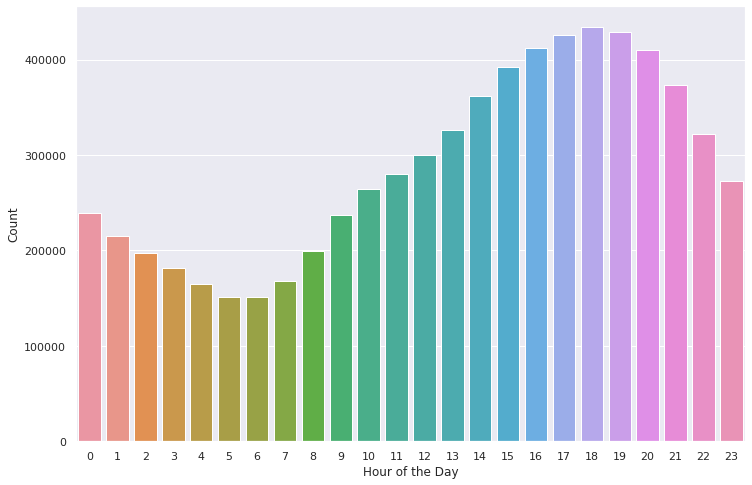

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Remember that the `timestamp` attribute is in Unix time, i.e. it is absolute in terms of timezone. The chart is showing us that events are mainly located in a single timezone, as the events decrease in the morning and increase in late afternoon.   

**Q1: Is there any listening pattern across hours of the day, separately by gender?**

Text(0, 0.5, 'Count')

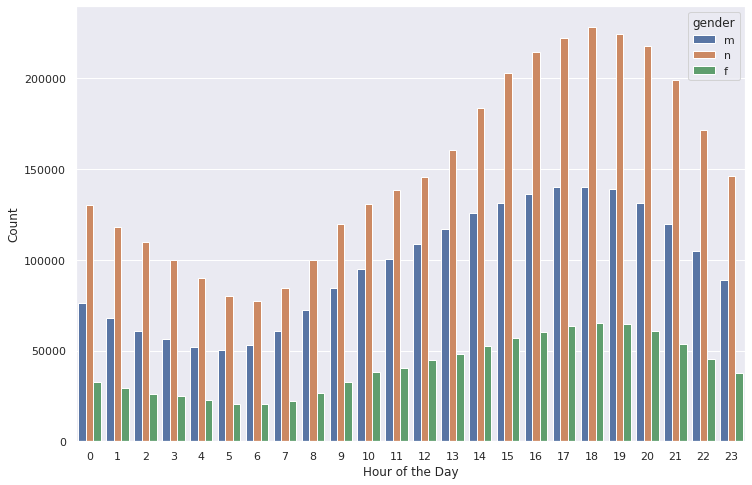

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod", hue="gender")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Judging by the chart, there seem to be no evident difference. Well, beware!